In [14]:
import random
import json
import re
import os

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


random.seed(6)
np.random.seed(6)


# Experiment 6
# Correlation of mispredictions between Llama3B and Llam8B

For this experiment I changed the system prompt, asking the LLM to generate more text (about "thinking") and then give the final answer.


**Parameters:**
- model: llama3.1:8b
- system prompt: MCQ_system_prompt_v3.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [15]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [16]:
llama3b_predictions = []
with open('../outputs/responses_llama3.2_20250210_20:17:23.jsonl') as f:
    llama3b_predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
llama3b_predictions = pd.DataFrame(llama3b_predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
llama3b_predictions.set_index('id', inplace=True)


llama8b_predictions = []
with open('../outputs/responses_llama3.1:8b_20250219_13:49:44.jsonl') as f:
    llama8b_predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
llama8b_predictions = pd.DataFrame(llama8b_predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
llama8b_predictions.set_index('id', inplace=True)



In [17]:
# Pattern for `A: (\digit\.)? <sequence of words>.`
#
# The digit is optional and the max length of the sequence must be of 10 words
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)'


## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [18]:
def extract_answers(df, pattern):

    ans_df = df['answer'].str.extract(pattern)
    ans_df.rename(columns={0: 'text'}, inplace=True)

    ans_df['text'] = ans_df['text'].str.strip()

    return ans_df

llama3b_ans = extract_answers(llama3b_predictions, ans_regex_pattern)
llama8b_ans = extract_answers(llama8b_predictions, ans_regex_pattern)


For now let's focus only on the responses for which both model have a correctly formatted answer, and thus it was possible to extract the answer with the regex pattern.

In [19]:
common_answers = llama3b_ans['text'].notna() & llama8b_ans['text'].notna()

llama3b_ans = llama3b_ans.loc[common_answers]
llama8b_ans = llama8b_ans.loc[common_answers]

print(f"Percentage of answers retained for the analysis: {common_answers.sum()/gt_df.shape[0]:.2%}")


Percentage of answers retained for the analysis: 89.69%


In [20]:
llama3b_correct_mask = (llama3b_ans['text'] == gt_df.loc[common_answers]['text'])
llama8b_correct_mask = (llama8b_ans['text'] == gt_df.loc[common_answers]['text'])

to_percent = lambda mask: mask.sum() / mask.shape[0]

print(f"Accuracy for Llam3b: {to_percent(llama3b_correct_mask):^10.2%}")
print(f"Accuracy for Llam8b: {to_percent(llama8b_correct_mask):^10.2%}")


Accuracy for Llam3b:   44.52%  
Accuracy for Llam8b:   58.81%  


In the next step we want to inspect if Llama8b is able to answers correctly all the question for which Lama3b provided a correct answers, in other words if the the set of correct answers of Llama8b is a superset of the correct answers of Llama3b.

In [21]:
# I am computing: (A & B) in B <-> A & B = A
# & as intersection
((llama3b_correct_mask & llama8b_correct_mask) == llama3b_correct_mask).all()


False

In [22]:
# number of answers which 3b gets right and 8b wrong
only3b_correct = llama3b_correct_mask & ~llama8b_correct_mask
both_correct = llama3b_correct_mask & llama8b_correct_mask

r = only3b_correct.sum()
print(f"Ratio of answers which only 3B gets right:")
print(f"- {r / llama3b_correct_mask.sum():.4f} of all 3B correct answers")
print(f"- {r / (~llama8b_correct_mask).sum():.4f} of all 8B wrong answers")
print(f"- {r / llama8b_ans.shape[0]:.4f} of all questions\n")

r = both_correct.sum()
print(f"Ratio of answers which both models get right:")
print(f"- {r / llama3b_correct_mask.sum():.4f} of all 3B correct answers")
print(f"- {r / llama8b_correct_mask.sum():.4f} of all 8B correct answers")
print(f"- {r / llama8b_ans.shape[0]:.4f} of all questions")


Ratio of answers which only 3B gets right:
- 0.2477 of all 3B correct answers
- 0.2677 of all 8B wrong answers
- 0.1103 of all questions

Ratio of answers which both models get right:
- 0.7523 of all 3B correct answers
- 0.5694 of all 8B correct answers
- 0.3349 of all questions


This results show that there are still some finetuning we are still missing and can get a 10% gain in performance.

Let's show the distribution of the question over the category to see if the answered correctly guessed obly by Llama3B are biased towards a category.

Ratio of Feasibility questions:          7.69%
Ratio of Interaction questions:          29.63%
Ratio of Prediction questions:           10.40%
Ratio of Sequence questions:             52.28%


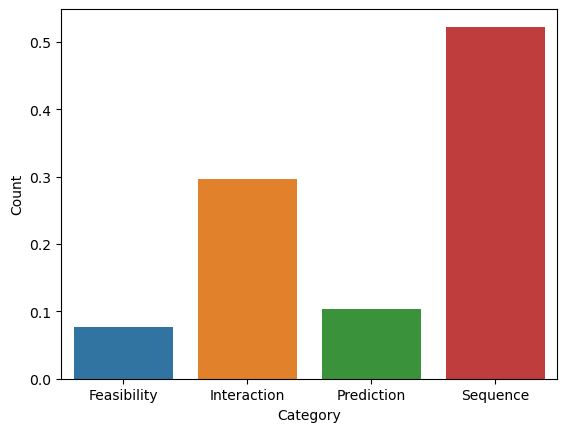

In [23]:
data = only3b_correct.groupby(by=lambda x: x.split('_')[0]).sum()

data = data.apply(lambda x: x/only3b_correct.sum())
df = data.reset_index()
df.columns = ['Category', 'Count']


sns.barplot(data=df, x='Category', y='Count')
for idx, val in data.items():
    print(f"{f'Ratio of {idx} questions:':<{40}} {val:^5.2%}")


Ratio of Feasibility questions:          6.90%
Ratio of Interaction questions:          33.78%
Ratio of Prediction questions:           8.79%
Ratio of Sequence questions:             50.52%


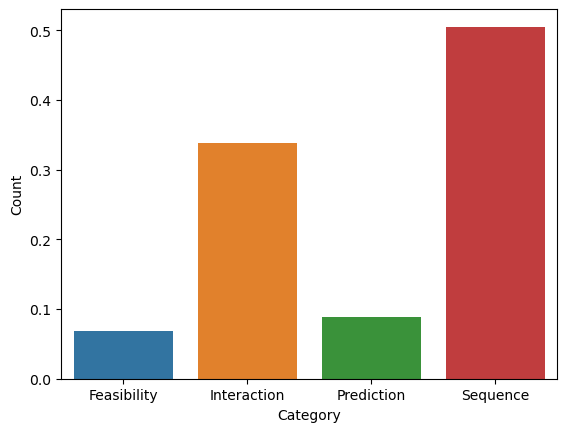

In [24]:
data = gt_df.groupby(by=lambda x: x.split('_')[0]).count()['text']

data = data.apply(lambda x: x/gt_df.shape[0])
df = data.reset_index()
df.columns = ['Category', 'Count']


sns.barplot(data=df, x='Category', y='Count')
for idx, val in data.items():
    print(f"{f'Ratio of {idx} questions:':<{40}} {val:^5.2%}")


As we can see there's no significant bias towards a single category, the distribution is simalr to that of the ground truth set.

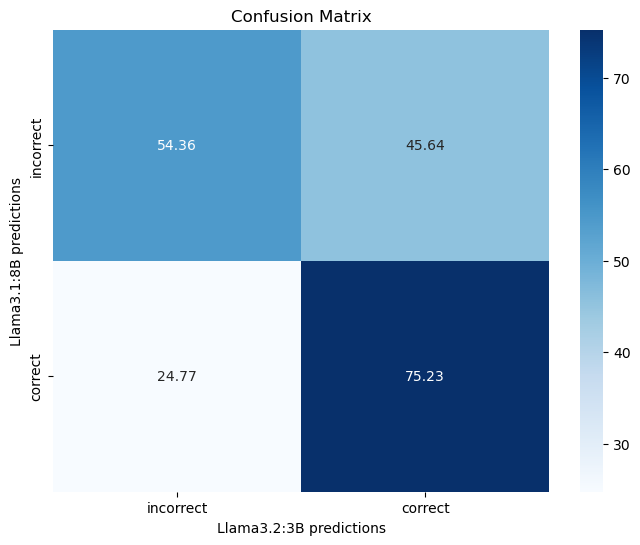

In [28]:
# Compute the confusion matrix

llama3b_pred_labels = llama3b_correct_mask.astype(int)
llamaa8b_pred_labels = llama8b_correct_mask.astype(int)

cm = confusion_matrix(llama3b_pred_labels, llamaa8b_pred_labels)

# Normalize the confusion matrix to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['incorrect', 'correct'], 
            yticklabels=['incorrect', 'correct'])
plt.xlabel('Llama3.2:3B predictions')
plt.ylabel('Llama3.1:8B predictions')
plt.title('Confusion Matrix')
plt.show()
